- Assess if temperature data can be predicted based on population data (and maybe other external input such as land cover type).

Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload
import os
from tqdm import tqdm

## Data description


#### Enact 2011 Population Grid
Datas of population: Monthly, 1000x1000m, European

#### UrbClim models: 
Monthly dataset, with hourly datas, 100x100m, Cities 
Air Temperature, Relative humidity, Specific humidity, Wind speed

Yearly dataset, 100x100m, Cities
Land-sea mask, Rural-urban mask

## Importing data

In [3]:
#Defining parameters

folder_path = 'data_UHI'
cities = ['Lyon']
number_of_sample_per_city = 100000


In [53]:
#Loading the moduke functions
reload(f)

#Loading data for Lyon
city_df = pd.DataFrame(columns=['temp', 'pop', 'deltaT', 'hour','isrural', 'city', 'landcover'])
for city in cities:
    for month in tqdm(range(1,13)):
        #Open the datasets
        if month < 10:
            str_month = '0'+str(month)
        
        #Setting paths
        temp_file_path = folder_path + '/tas_'+ city +'_UrbClim_2011_'+ str_month +'_v1.0.nc'
        rural_mask_file_path = folder_path +'/ruralurbanmask_'+city +'_UrbClim_v1.0.nc'

        #Open the datasets
        pop_day = rio.open(folder_path + f'/ENACT_POP_D{str_month}2011_EU28_R2020A_4326_30ss_V1_0.tif')
        pop_night = rio.open(folder_path + f'/ENACT_POP_N{str_month}2011_EU28_R2020A_4326_30ss_V1_0.tif')
        rural_mask_file = xr.open_dataset(rural_mask_file_path)
        temp_file = xr.open_dataset(temp_file_path)
        land_cover = rio.open(folder_path + '/MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif')

        #Crop and resample the datasets
        cropped_pop_day, cropped_pop_night, temp_file_red= f.crop_and_downgrade(pop_day, pop_night, temp_file)
        pop_day_city = f.resample_image(cropped_pop_day, temp_file.tas[0,:,:].shape)
        pop_night_city = f.resample_image(cropped_pop_night, temp_file.tas[0,:,:].shape)
        populations = np.concatenate([np.tile(pop_night_city.flatten(),8), np.tile(pop_day_city.flatten(), 12), np.tile(pop_night_city.flatten(), 4)])
        populations = np.tile(populations, 31)
        
        lc_city = f.crop_image(land_cover, temp_file)
        lc_city = f.resample_image(lc_city, temp_file.tas[0,:,:].shape)
        lc_flatten = np.tile(lc_city.flatten(), temp_file.tas.shape[0])

        latitude = np.tile(temp_file.latitude.values.flatten(), temp_file.tas.shape[0])
        longitude = np.tile(temp_file.longitude.values.flatten(), temp_file.tas.shape[0])

        day_hours = np.tile(np.arange(0,24), temp_file.x.shape[0]*temp_file.y.shape[0])
        hours = np.tile(day_hours.reshape(temp_file.x.shape[0]*temp_file.y.shape[0], 24).flatten(order='F'), 31)

        deltaT = f.compute_deltaT_urban(temp_file, rural_mask_file)
        rural = np.tile(rural_mask_file.ruralurbanmask.values.flatten(), temp_file.tas.shape[0])
        city_data = np.tile(np.array([city]), number_of_sample_per_city)

        #generate random indexes to sample the data
        indexes = np.random.randint(0, temp_file.tas.shape[0]*temp_file.tas.shape[1]*temp_file.tas.shape[2], number_of_sample_per_city)
        city_df = pd.concat([city_df, pd.DataFrame({'temp': temp_file.tas.values.flatten()[indexes],
                                                    'pop':populations[indexes], 
                                                    'deltaT': deltaT[indexes],
                                                    'hour': hours[indexes],
                                                    'isrural' : rural[indexes],
                                                    'landcover':lc_flatten[indexes],
                                                    'city' : city_data})])


  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\broth\AppData\Local\Temp\ipykernel_1604\134542018.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  city_df = pd.concat([city_df, pd.DataFrame({'temp': temp_file.tas.values.flatten()[indexes],
100%|██████████| 12/12 [02:30<00:00, 12.54s/it]


In [54]:
city_df.sample(5)

,temp,pop,deltaT,hour,isrural,city,landcover
97373,272.018433,84.383261,-3.159302,4,1.0,Lyon,15.0
23429,289.261108,385.236302,-0.760223,9,1.0,Lyon,22.0
99726,276.891357,16.658303,-0.403015,12,1.0,Lyon,22.0
5678,282.202087,681.184807,1.585510,1,NaN,Lyon,31.0
78914,279.084686,4.912417,-1.085754,18,1.0,Lyon,31.0


## Importing data file with several citys

In [2]:
#read csv
city_df = pd.read_csv('data_UHI/city_df.csv')
city_df

,Unnamed: 0,temp,pop,wind,hum,deltaT,hour,elevation,city,land cover type,NDVI,isrural
0,0,281.35278,285.543419,5.941941,87.613120,0.313812,13,0.0,Amsterdam,22.0,0.656,NaN
1,1,281.29950,2079.376626,4.617371,89.986496,1.010040,23,2.0,Amsterdam,1.0,0.484,NaN
2,2,279.94104,1034.983036,4.149638,96.205060,0.453522,16,0.0,Amsterdam,22.0,0.504,1.0
3,3,283.49870,5190.469045,6.183427,89.858620,0.811554,9,4.0,Amsterdam,22.0,0.496,NaN
4,4,281.49980,15.525342,4.936266,88.591880,0.123962,18,0.0,Amsterdam,22.0,0.844,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2214902,39123,274.69473,0.000000,2.478448,85.524410,0.015808,20,364.0,Vienna,14.0,0.848,1.0
2214903,39124,274.69904,0.000656,1.162881,89.303630,-0.917358,2,150.0,Vienna,31.0,0.496,1.0
2214904,39125,275.36008,0.000000,2.320185,69.826440,0.333801,12,376.0,Vienna,14.0,0.812,NaN
2214905,39126,279.29022,4834.806318,0.537743,72.876915,3.060089,0,246.0,Vienna,22.0,0.544,NaN


## Data Formatting

The columns not useful for the training are dropped, e.g. ('city')
We then restrict the analysis to the urban zone, by choosing only features with 'isrural' == 1.
The data is then scaled. 

The analysis aims at identifying the population based on attributes such as heat islands (namely 'deltaT') and Land Cover. 

Finally the data is split between train and test set. 


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


scaler = StandardScaler()
df_sample = city_df.drop('city', axis=1)
#df_sample['isrural'] = df_sample['isrural'].fillna(1)

#df_sample = df_sample[df_sample['isrural'] == 1]
df_5000 = df_sample[df_sample['pop'] > 5000]

df_2500 = df_sample[df_sample['pop'] < 5000]
df_2500 = df_2500[df_2500['pop'] > 2500]

df_1000 = df_sample[df_sample['pop'] < 2500]
df_1000 = df_1000[df_1000['pop'] > 1000]

df_0 = df_sample[df_sample['pop'] < 1000]
df_0 = df_0[df_0['pop'] > 0]


dfs = [df_sample, df_5000, df_2500, df_1000, df_0]



## Data approach

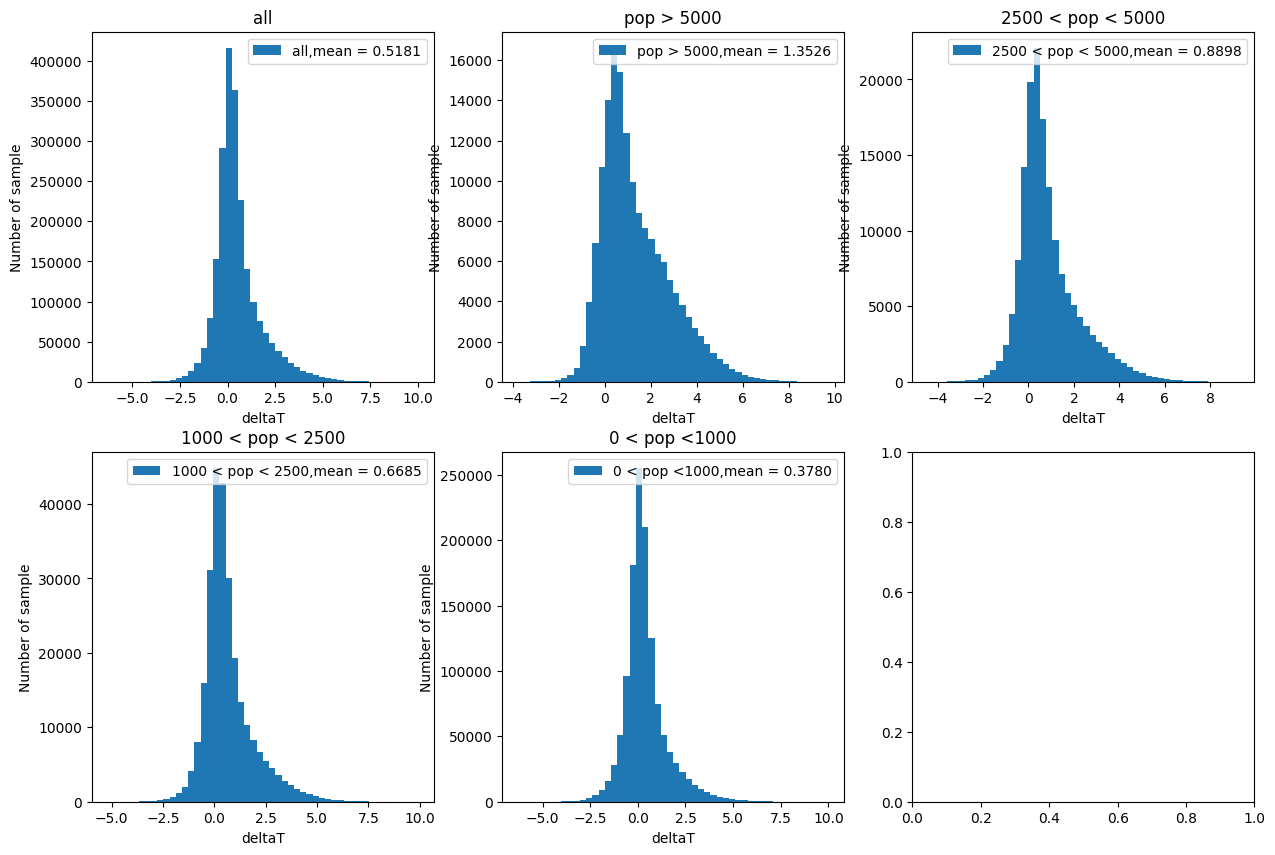

In [5]:
#plot histogram of delta T for all the dataframes with 2 side by side plots
df_legends =   ['all','pop > 5000', '2500 < pop < 5000', '1000 < pop < 2500','0 < pop <1000']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, df in enumerate(dfs):
    axs[i].hist(df['deltaT'], bins=50, label = df_legends[i] + f',mean = {df["deltaT"].mean():.4f}')
    axs[i].set_title(df_legends[i])
    axs[i].legend()
    axs[i].set_xlabel('deltaT')
    axs[i].set_ylabel('Number of sample')

## Machine Learning methods

In [4]:
# Importing the modules
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [5]:
for i, df in enumerate(dfs):
    df = df[df['isrural'] == 1]
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    dfs[i] = df

X = dfs[0].drop(['temp', 'pop', 'hour', 'isrural', 'Unnamed: 0', 'wind', 'hum', 'elevation'], axis=1)
y = dfs[0]['pop']

#split the data in training, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train

,deltaT,land cover type,NDVI
87009,-0.178908,0.722214,0.675522
280318,0.017915,-0.398941,-0.357770
984152,0.544538,0.722214,0.541577
623902,-1.590737,-0.398941,-0.357770
1027331,-0.214451,0.722214,1.019952
...,...,...,...
451017,0.162968,-1.769242,0.924277
604448,2.526011,-0.398941,0.101471
1005635,0.097783,0.722214,0.216281
999906,2.126601,0.722214,-0.089879


In [15]:
methods = [LinearRegression(), Ridge(), MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, activation='relu', solver='adam', random_state=42), RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42), GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42), ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=4)]
r2s = []
MSEs = []
for method in methods: 
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    print(method)
    print("MSE: ", mean_squared_error(y_test, y_pred))
    print("R2: ", r2_score(y_test, y_pred))
    MSEs.append(mean_squared_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))

LinearRegression()
MSE:  0.9166292273739672
R2:  0.08694166798592506
Ridge()
MSE:  0.9166292277775124
R2:  0.08694166758395205
MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=42)
MSE:  0.6941394587846547
R2:  0.30856468733950226
RandomForestRegressor(max_depth=10, random_state=42)
MSE:  0.6150544365856433
R2:  0.38734161949471646
GradientBoostingRegressor(max_depth=10, random_state=42)
MSE:  0.6027053392382691
R2:  0.3996426086942161
ExtraTreesRegressor(max_depth=10, random_state=4)
MSE:  0.6643420543004962
R2:  0.33824601063158033


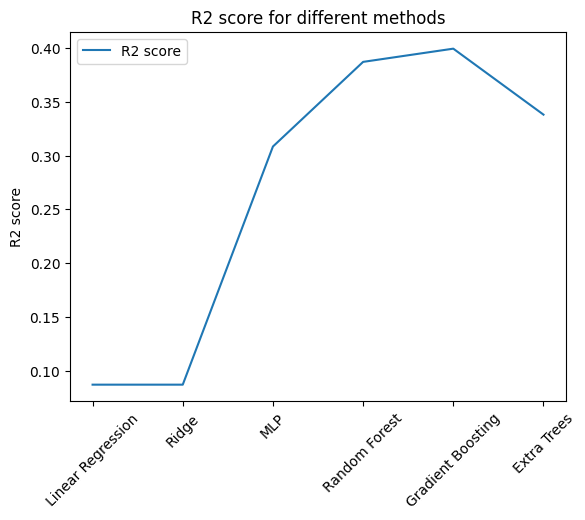

In [16]:
plt.plot(r2s, label = 'R2 score')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), ('Linear Regression', 'Ridge', 'MLP', 'Random Forest', 'Gradient Boosting', 'Extra Trees'), rotation = 45)

plt.legend()

plt.title('R2 score for different methods')
plt.show()

In [6]:
# best algortihm is the gradient boosting regressor 
# we will now try to finetune the hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': sp_randint(10, 150),
               'max_features': ['auto', 'sqrt'],
               'max_depth': sp_randint(5, 100),
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(1, 8)}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_val, y_val)
rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 